In [1]:
#!pip install labelme opencv-python matplotlib albumentations pandas uuid

In [1]:
import os
import time
import uuid
import cv2
import tensorflow as tf
import json
import numpy as np
#import albumentations as alb
from matplotlib import pyplot as plt

In [3]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Capture Image

In [148]:
IMAGES_PATH = os.path.join('data','images')
number_images = 40

In [153]:
cap = cv2.VideoCapture(0)

for imgnum in range(number_images):
    print('Collecting image {}'.format(imgnum))
    ret, frame = cap.read()
    imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    time.sleep(0.5)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

In [155]:
!labelme #Label the data

## Load images as TF MAP

In [158]:
def load_image(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [159]:
images = images.map(load_image)

In [160]:
images.as_numpy_iterator().next()

array([[[173, 183, 182],
        [173, 183, 182],
        [175, 184, 183],
        ...,
        [159, 161, 160],
        [155, 157, 156],
        [152, 154, 153]],

       [[172, 181, 180],
        [172, 181, 180],
        [173, 182, 181],
        ...,
        [158, 160, 159],
        [156, 158, 157],
        [154, 156, 155]],

       [[174, 180, 180],
        [174, 180, 180],
        [175, 181, 181],
        ...,
        [159, 161, 158],
        [157, 159, 156],
        [156, 158, 155]],

       ...,

       [[ 69,  68,  66],
        [ 68,  67,  65],
        [ 71,  67,  66],
        ...,
        [ 48,  46,  47],
        [ 46,  44,  45],
        [ 46,  44,  45]],

       [[ 79,  75,  74],
        [ 82,  78,  77],
        [ 88,  84,  81],
        ...,
        [ 48,  46,  47],
        [ 47,  45,  48],
        [ 48,  46,  49]],

       [[102,  98,  97],
        [106, 102, 101],
        [106, 102,  99],
        ...,
        [ 48,  46,  47],
        [ 48,  46,  49],
        [ 49,  47,  50]]

In [161]:
type(images)

tensorflow.python.data.ops.dataset_ops.MapDataset

In [162]:
image_generator = images.batch(4).as_numpy_iterator()

In [163]:
plot_images = image_generator.next()

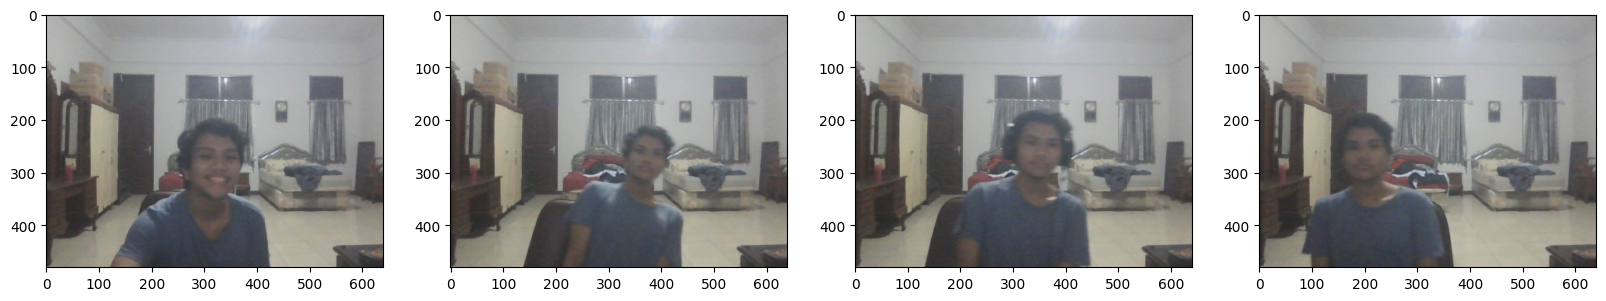

In [164]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()

In [ ]:
# Move manually with 70-15-15 split, would like to experiment with it. Usually would use train_test_split from sklearn

In [165]:
# Automatically move .json files (coordinates of bounding box and the label)

for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)

## Data Augmentations

In [6]:
import albumentations as alb

In [7]:
augmentor = alb.Compose([
    alb.RandomCrop(width=450, height=450),
    alb.HorizontalFlip(p=0.5),
    alb.RandomBrightnessContrast(p=0.3),
    alb.RandomGamma(p=0.1),
    alb.RGBShift(p=0.1),
    alb.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=15, p=0.5)
], bbox_params=alb.BboxParams(format='albumentations', label_fields=['class_labels']))

### Test on a single data

In [592]:
img = cv2.imread(os.path.join('data','train', 'images','3de4bb33-0809-11ee-8c10-b0a4600344d6.jpg'))

In [593]:
with open(os.path.join('data', 'train', 'labels', '3de4bb33-0809-11ee-8c10-b0a4600344d6.json'), 'r') as f:
    label = json.load(f)

In [594]:
label['shapes'][0]['label']

'ryan neutral'

In [595]:
import pandas as pd

df = pd.DataFrame(label['shapes'])

In [596]:
df.head()

,label,points,group_id,description,shape_type,flags
0,ryan neutral,"[[270.0, 93.84615384615385], [405.897435897435...",None,,rectangle,{}


--- 

In [597]:
type(label)

dict

In [598]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [599]:
coords

[270.0, 93.84615384615385, 405.8974358974359, 265.12820512820514]

In [600]:
# Reduce range to 0-1
coords = list(np.divide(coords, [640,480,640,480]))

In [601]:
coords

[0.421875, 0.19551282051282054, 0.6342147435897436, 0.5523504273504274]

In [602]:
# Augment data
augmented = augmentor(image=img, bboxes=[coords], class_labels=['ryan, happy'])

In [603]:
augmented['bboxes'][0][2:]

(0.5108831908831909, 0.5425071225071225)

In [604]:
augmented['bboxes']

[(0.2088888888888889,
  0.1618803418803419,
  0.5108831908831909,
  0.5425071225071225)]

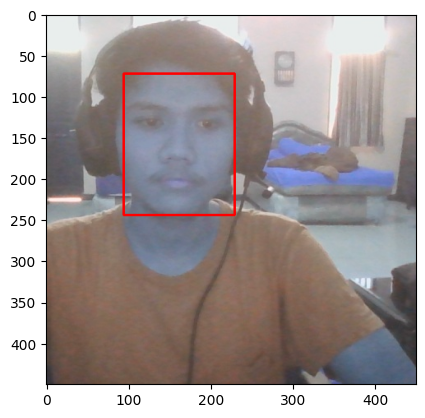

In [605]:
# Plot the image with bounding box
cv2.rectangle(augmented['image'],
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)), 
                    (255,0,0), 2)

plt.imshow(augmented['image'])

---

## Pre-processing the data (One-hot encode, transformation)

In [8]:
import cv2
import json
import os
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# Initialize the label encoder
label_encoder = LabelEncoder()

# Define the class names
class_names = ['ryan happy', 'ryan sad', 'ryan neutral']

# Fit the label encoder on the class names
label_encoder.fit(class_names)

# Convert the class names to numerical labels
numerical_labels = label_encoder.transform(class_names)

# Initialize the one-hot encoder
one_hot_encoder = OneHotEncoder(sparse=False)

# Fit the one-hot encoder on the numerical labels
one_hot_encoder.fit(numerical_labels.reshape(-1, 1))

# Function to perform one-hot encoding
def one_hot_encode(label):
    numerical_label = label_encoder.transform([label])[0]
    one_hot_label = one_hot_encoder.transform([[numerical_label]])
    return one_hot_label[0].tolist()

for partition in ['train', 'test', 'val']:
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0, 0, 0.00001, 0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640, 480, 640, 480]))
            classes = label['shapes'][0]['label']

        try:
            for x in range(80):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=[classes])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0:
                        annotation['bbox'] = [0, 0, 0, 0]
                        annotation['class'] = [0.0, 0.0, 0.0]
                    else:
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = one_hot_encode(augmented['class_labels'][0])
                else:
                    annotation['bbox'] = [0, 0, 0, 0]
                    annotation['class'] = [0.0, 0.0, 0.0]

                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

C:\Users\mryan\anaconda3\envs\Tensorflow\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


---

## Load the images

In [9]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [10]:
train_images = tf.data.Dataset.list_files('aug_data/train/images/*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [11]:
test_images = tf.data.Dataset.list_files('aug_data/test/images/*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [12]:
val_images = tf.data.Dataset.list_files('aug_data/val/images/*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [13]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

## Load the labels

In [14]:
train_labels = tf.data.Dataset.list_files('aug_data/train/labels/*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.float16, tf.float16]))

In [15]:
import json
train_labels.as_numpy_iterator().next()

(array([[0., 1., 0.]], dtype=float16),
 array([0.6265, 0.4507, 0.835 , 0.65  ], dtype=float16))

In [16]:
test_labels = tf.data.Dataset.list_files('aug_data/test/labels/*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.float16, tf.float16]))

In [17]:
val_labels = tf.data.Dataset.list_files('aug_data/val/labels/*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.float16, tf.float16]))

In [18]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(9920, 9920, 2720, 2720, 2560, 2560)

---

### Create a Dataset by zipping together the given train_images and train_labels dataset

In [22]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(10000)
train = train.batch(8)
train = train.prefetch(4)

In [23]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(6000)
test = test.batch(8)
test = test.prefetch(4)

In [24]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(6000)
val = val.batch(8)
val = val.prefetch(4)

---

## Test the bounding-box on a batch of data

In [182]:
data_samples = train.as_numpy_iterator()

In [183]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


sample_coords: [0.6553 0.4517 0.8286 0.6353]
sample_coords: [0.17   0.4487 0.3513 0.622 ]
sample_coords: [0.974  0.1953 1.     0.4048]
sample_coords: [0.829  0.3118 1.     0.699 ]


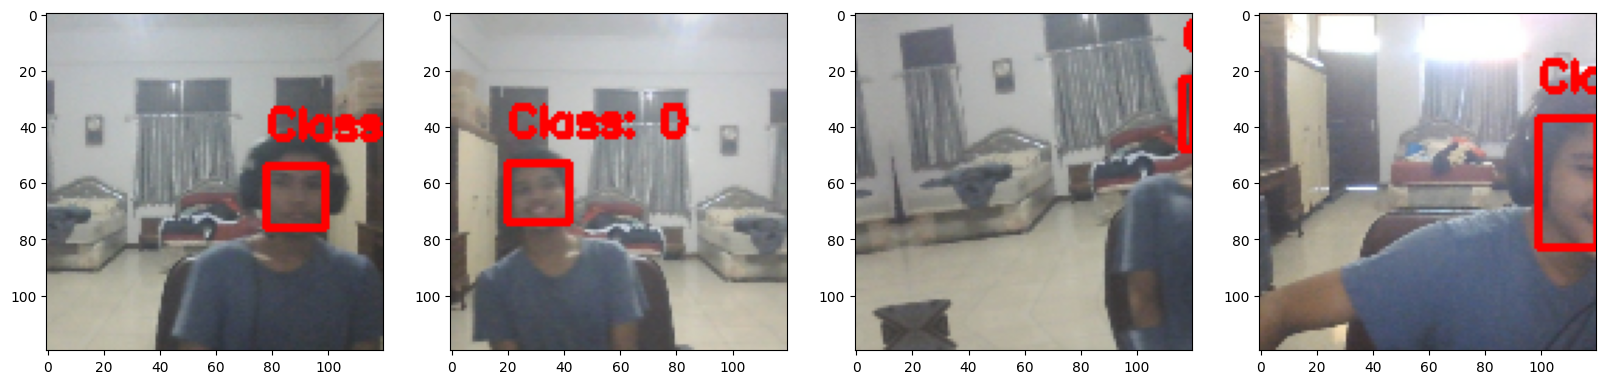

In [187]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    predicted_class = np.argmax(res[1][0][idx])

    print(f"sample_coords: {sample_coords}")  # Debugging line
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120, 120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120, 120]).astype(int)), 
                  (255, 0, 0), 2)
    
    class_label = f"Class: {predicted_class}"
    cv2.putText(sample_image, class_label, 
                tuple(np.add(np.multiply(sample_coords[:2], [120, 120]).astype(int), [0, -10])),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
    
    ax[idx].imshow(sample_image)

## Model Building (Transfer Learning VGG16)

In [20]:
from tensorflow.keras.applications import VGG16
vgg = VGG16(include_top=False)

In [21]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [25]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

def build_model(): 
    input_layer = Input(shape=(120,120,3)) #120x120 picture, RGB
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(3, activation='softmax')(class1) #Softmax function for label
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1) #Sigmoid function for bounding-box
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

In [26]:
facetracker = build_model()

In [27]:
facetracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_2[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d (GlobalMa  (None, 512)         0           ['vgg16[0][0]']                  
 xPooling2D)                                                                                  

In [28]:
X, y = train.as_numpy_iterator().next()

In [29]:
X.shape, y[0].shape, y[1].shape

((8, 120, 120, 3), (8, 1, 3), (8, 4))

In [30]:
# Test model prediction
classes, coords = facetracker.predict(X)

1/1 [==============================] - 6s 6s/step


In [32]:
print(y)

(array([[[0., 0., 1.]],

       [[0., 0., 1.]],

       [[1., 0., 0.]],

       [[0., 1., 0.]],

       [[0., 0., 0.]],

       [[1., 0., 0.]],

       [[0., 1., 0.]],

       [[0., 0., 1.]]], dtype=float16), array([[0.826 , 0.2151, 0.9204, 0.6855],
       [0.1663, 0.218 , 0.4512, 0.5703],
       [0.873 , 0.4587, 1.    , 0.632 ],
       [0.519 , 0.1755, 0.8037, 0.5264],
       [0.    , 0.    , 0.    , 0.    ],
       [0.5513, 0.4634, 0.733 , 0.616 ],
       [0.4675, 0.191 , 0.7524, 0.542 ],
       [0.7446, 0.3408, 0.9497, 0.7285]], dtype=float16))


In [33]:
classes, coords

(array([[0.2565091 , 0.47195104, 0.27153987],
        [0.34094414, 0.42404014, 0.23501578],
        [0.30296385, 0.41886908, 0.2781671 ],
        [0.38680765, 0.3594814 , 0.253711  ],
        [0.32976225, 0.39826116, 0.27197665],
        [0.2687835 , 0.41624364, 0.3149729 ],
        [0.3775686 , 0.33404467, 0.28838673],
        [0.32867342, 0.41258028, 0.2587463 ]], dtype=float32),
 array([[0.57304424, 0.40091679, 0.3650903 , 0.36997095],
        [0.58761096, 0.4738969 , 0.35897312, 0.3317915 ],
        [0.58780277, 0.42254686, 0.38430056, 0.39955592],
        [0.6101277 , 0.4367905 , 0.3595111 , 0.32339555],
        [0.60272384, 0.44790745, 0.3825728 , 0.3669707 ],
        [0.59034604, 0.49830425, 0.38622928, 0.38468605],
        [0.6302781 , 0.4132987 , 0.36130136, 0.33199707],
        [0.6073308 , 0.45379454, 0.40439546, 0.3226909 ]], dtype=float32))

## Defining Losses and Optimizers

In [34]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [35]:
opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001, decay=lr_decay)

In [36]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [37]:
classloss = tf.keras.losses.CategoricalCrossentropy()
regressloss = localization_loss

In [38]:
y[1], coords

(array([[0.826 , 0.2151, 0.9204, 0.6855],
        [0.1663, 0.218 , 0.4512, 0.5703],
        [0.873 , 0.4587, 1.    , 0.632 ],
        [0.519 , 0.1755, 0.8037, 0.5264],
        [0.    , 0.    , 0.    , 0.    ],
        [0.5513, 0.4634, 0.733 , 0.616 ],
        [0.4675, 0.191 , 0.7524, 0.542 ],
        [0.7446, 0.3408, 0.9497, 0.7285]], dtype=float16),
 array([[0.57304424, 0.40091679, 0.3650903 , 0.36997095],
        [0.58761096, 0.4738969 , 0.35897312, 0.3317915 ],
        [0.58780277, 0.42254686, 0.38430056, 0.39955592],
        [0.6101277 , 0.4367905 , 0.3595111 , 0.32339555],
        [0.60272384, 0.44790745, 0.3825728 , 0.3669707 ],
        [0.59034604, 0.49830425, 0.38622928, 0.38468605],
        [0.6302781 , 0.4132987 , 0.36130136, 0.33199707],
        [0.6073308 , 0.45379454, 0.40439546, 0.3226909 ]], dtype=float32))

In [39]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=3.879753>

In [40]:
y[0], classes

(array([[[0., 0., 1.]],
 
        [[0., 0., 1.]],
 
        [[1., 0., 0.]],
 
        [[0., 1., 0.]],
 
        [[0., 0., 0.]],
 
        [[1., 0., 0.]],
 
        [[0., 1., 0.]],
 
        [[0., 0., 1.]]], dtype=float16),
 array([[0.2565091 , 0.47195104, 0.27153987],
        [0.34094414, 0.42404014, 0.23501578],
        [0.30296385, 0.41886908, 0.2781671 ],
        [0.38680765, 0.3594814 , 0.253711  ],
        [0.32976225, 0.39826116, 0.27197665],
        [0.2687835 , 0.41624364, 0.3149729 ],
        [0.3775686 , 0.33404467, 0.28838673],
        [0.32867342, 0.41258028, 0.2587463 ]], dtype=float32))

In [41]:
classloss(np.squeeze(y[0], axis=1), classes)

<tf.Tensor: shape=(), dtype=float32, numpy=1.0914025>

## Define FaceTracker Custom Training Steps

In [42]:
class FaceTracker(Model): 
    def __init__(self, facetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = facetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs):
        X, y = batch

        with tf.GradientTape() as tape:
            classes, coords = self.model(X, training=True)

            batch_classloss = self.closs(tf.squeeze(y[0], axis=1), classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)

            total_loss = batch_localizationloss + 0.5 * batch_classloss

            grad = tape.gradient(total_loss, self.model.trainable_variables)

        self.opt.apply_gradients(zip(grad, self.model.trainable_variables))

        return {"total_loss": total_loss, "class_loss": batch_classloss, "regress_loss": batch_localizationloss}

    def test_step(self, batch, **kwargs):
        X, y = batch

        classes, coords = self.model(X, training=False)

        batch_classloss = self.closs(tf.squeeze(y[0], axis=1), classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss + 0.5 * batch_classloss

        return {"total_loss": total_loss, "class_loss": batch_classloss, "regress_loss": batch_localizationloss}

        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [43]:
model = FaceTracker(facetracker)

In [44]:
model.compile(opt, classloss, regressloss)

In [45]:
logdir='logs'

In [46]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [47]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
1240/1240 [==============================] - 168s 118ms/step - total_loss: 0.4929 - class_loss: 0.4853 - regress_loss: 0.2503 - val_total_loss: 0.1553 - val_class_loss: 0.0868 - val_regress_loss: 0.1119
Epoch 2/20
1240/1240 [==============================] - 154s 111ms/step - total_loss: 0.1295 - class_loss: 0.0679 - regress_loss: 0.0956 - val_total_loss: 0.0414 - val_class_loss: 0.0085 - val_regress_loss: 0.0372
Epoch 3/20
1240/1240 [==============================] - 153s 111ms/step - total_loss: 0.0753 - class_loss: 0.0264 - regress_loss: 0.0621 - val_total_loss: 0.1073 - val_class_loss: 0.1193 - val_regress_loss: 0.0477
Epoch 4/20
1240/1240 [==============================] - 153s 111ms/step - total_loss: 0.0541 - class_loss: 0.0152 - regress_loss: 0.0465 - val_total_loss: 0.0727 - val_class_loss: 0.0327 - val_regress_loss: 0.0564
Epoch 5/20
1240/1240 [==============================] - 153s 110ms/step - total_loss: 0.0353 - class_loss: 0.0073 - regress_loss: 0.0316 - val_t

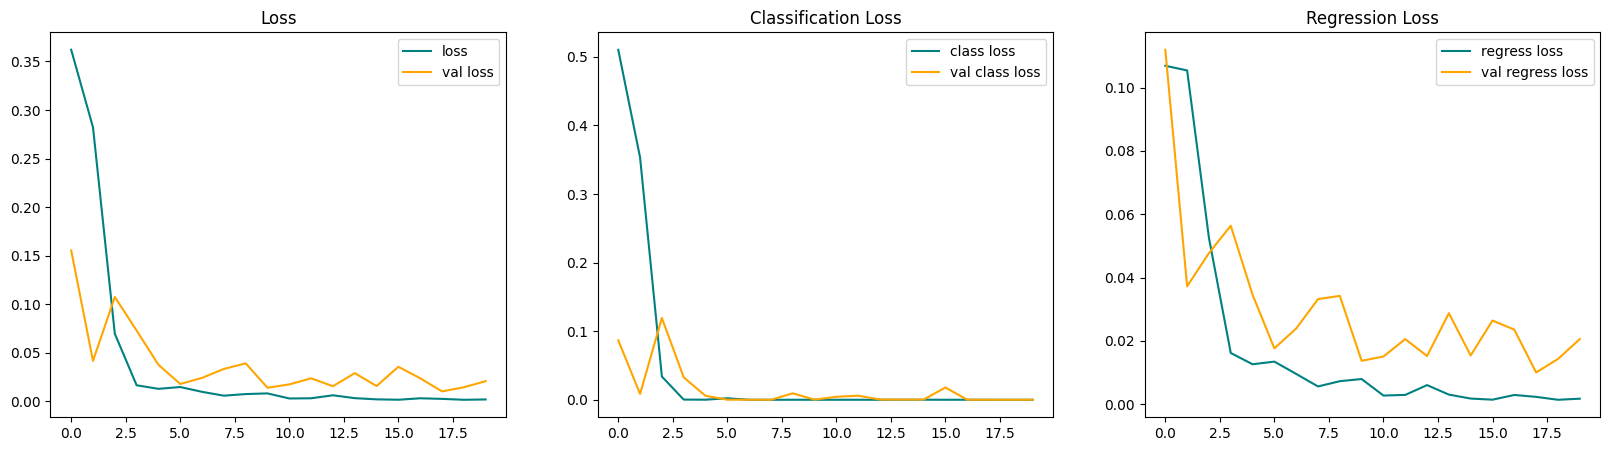

In [48]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

In [49]:
test_data = test.as_numpy_iterator()
test_sample = test_data.next()

In [2]:
facetracker.save('facetracker_v3.h5')

In [50]:
yhat = facetracker.predict(test_sample[0])

1/1 [==============================] - 0s 31ms/step


In [51]:
print(yhat[0])

[[8.6883283e-08 9.9999928e-01 6.0685989e-07]
 [4.5281837e-07 9.9999428e-01 5.2954042e-06]
 [1.0233878e-07 2.5760289e-06 9.9999738e-01]
 [3.7240901e-03 8.3986688e-01 1.5640903e-01]
 [9.9996412e-01 3.5865945e-05 9.9964348e-09]
 [8.9386318e-05 9.9990964e-01 9.0846174e-07]
 [9.9999988e-01 8.8288601e-08 8.3062932e-12]
 [2.5447539e-12 3.0021030e-09 1.0000000e+00]]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


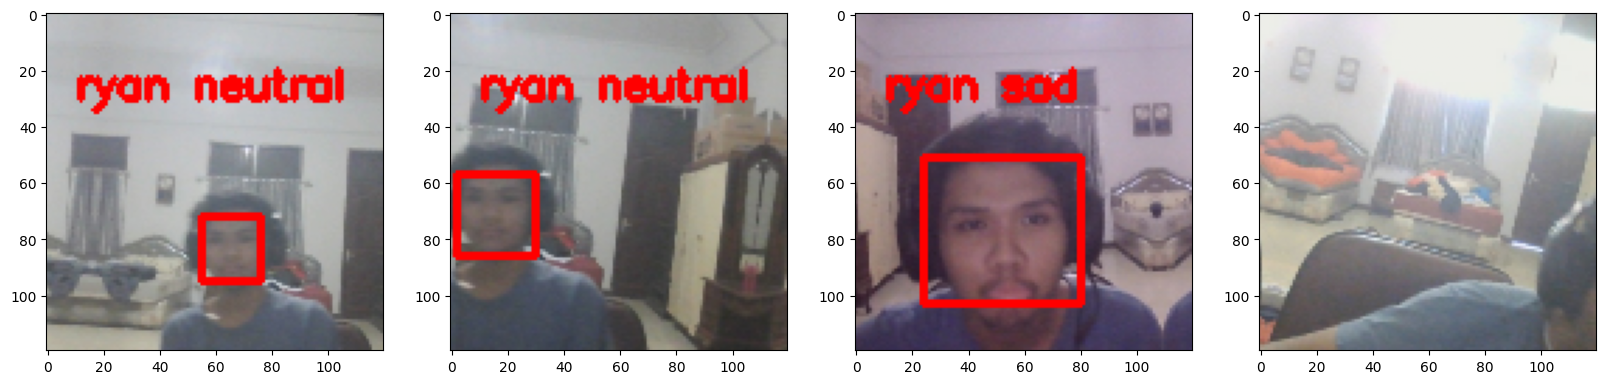

In [52]:
class_names = ['ryan happy','ryan neutral','ryan sad']

fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx in range(4):
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    predicted_class = np.argmax(yhat[0][idx])
    confidence = yhat[0][idx][predicted_class]

    if confidence > 0.9:
        cv2.rectangle(sample_image,
                      tuple(np.multiply(sample_coords[:2], [120, 120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120, 120]).astype(int)),
                      (255, 0, 0), 2)

        class_name = class_names[predicted_class]
        cv2.putText(sample_image, class_name,
                    (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    ax[idx].imshow(sample_image)

## Test the Model on Real-Time Data using OpenCV

In [1]:
import tensorflow as tf
from tensorflow.keras.models import load_model

In [2]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
facetracker = load_model('facetracker_v3.h5')

In [5]:
import cv2
import numpy as np

# ... Code to initialize and load the facetracker model ...

class_names = ['Happy', 'Neutral', 'Neutral']

# Create a CUDA-enabled version of cv2
cv2_cuda = cv2.cuda

cap = cv2.VideoCapture(1)

while cap.isOpened():
    ret, frame = cap.read()

    if not ret:
        break

    frame = frame[50:500, 50:500, :]

    # Upload the frame to a cv2.cuda.GpuMat object
    frame_gpu = cv2_cuda.GpuMat()
    frame_gpu.upload(frame)

    # Convert the color channel order using CUDA-accelerated function
    frame_rgb = cv2_cuda.cvtColor(frame_gpu, cv2.COLOR_BGR2RGB)
    
    # Resize the frame using CUDA-accelerated function
    resized = cv2_cuda.resize(frame_rgb, (120, 120))

    # Convert CUDA GpuMat to NumPy array
    resized = resized.download()

    # ... Perform other CUDA-accelerated operations ...

    # Convert the resized image to TensorFlow format (if required)

    yhat = facetracker.predict(np.expand_dims(resized / 255, 0))

    if np.any(yhat[0]):
        sample_coords = yhat[1][0]
        predicted_class = np.argmax(yhat[0][0])
        confidence = yhat[0][0][predicted_class]

        # Controls the main rectangle
        cv2.rectangle(frame,
                      tuple(np.multiply(sample_coords[:2], [450, 450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450, 450]).astype(int)),
                      (255, 0, 0), 1)

        # Controls the label rectangle
        cv2.rectangle(frame,
                      tuple(np.add(np.multiply(sample_coords[:2], [450, 450]).astype(int), [0, -20])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450, 450]).astype(int), [150, 0])),
                      (255, 0, 0), -1)

        # Controls the text rendered
        class_name = class_names[predicted_class]
        confidence_rate = f'{confidence:.2f}'
        text = f'{class_name} ({confidence_rate})'
        cv2.putText(frame, text,
                    (int(sample_coords[0] * 450), int(sample_coords[1] * 450) - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

    cv2.imshow('Facetracker', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 23ms/step


In [5]:
cap.release()
cv2.destroyAllWindows()